1. Load the data.
2. Analysis the data.
    - Distribution etc
3. Clean the data
    - Handle null values
    - One hot encode values (Explain: I can't tell and No emotion towards the brand)
    - Clean the text data e.g remove hashtags, username and links
4. Pre Processing
5. Build the model
6. Test the model.

In [1]:
import pandas as pd

# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'tweet_product_company.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path, encoding='latin-1')

# Display the DataFrame
print(df)

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
0                             iPhone   
1                 iPad or iPhone App   
2                               iPad   
3                 iPad or iPhone App   
4                             Google   
...                              ...   
9088       

In [2]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [3]:
missing_values = df.isnull().sum()
print(missing_values)


tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [4]:
# Explore 'tweet_text' column
tweet_text_distribution = df['tweet_text'].value_counts()

# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

# Explore 'is_there_an_emotion_directed_at_a_brand_or_product' column
emotion_directed_at_distribution = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Display the distributions
print("Distribution of 'tweet_text' values:")
print(tweet_text_distribution)

print("\nDistribution of 'emotion_in_tweet_is_directed_at' values:")
print(emotion_distribution)

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)


Distribution of 'tweet_text' values:
tweet_text
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                 5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                              4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                 4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                              3
RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter                                       2
                                                                                                                                              ..
Great interview to @mention on Bloomberg TV about #Ipad2 to kick off #SxSW.#apple 

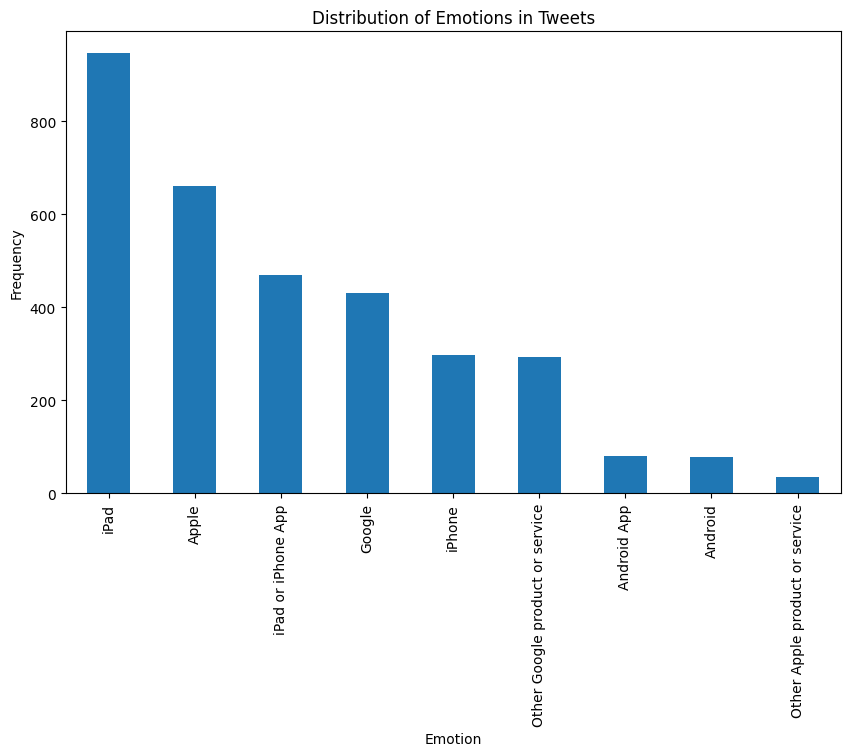

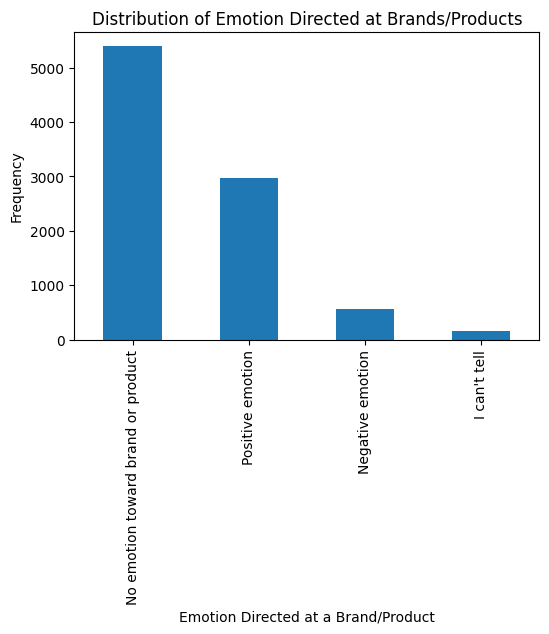

In [5]:
import matplotlib.pyplot as plt

# Bar chart for 'emotion_in_tweet_is_directed_at'
plt.figure(figsize=(10, 6))
emotion_distribution.plot(kind='bar')
plt.title('Distribution of Emotions in Tweets')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

# Bar chart for 'is_there_an_emotion_directed_at_a_brand_or_product'
plt.figure(figsize=(6, 4))
emotion_directed_at_distribution.plot(kind='bar')
plt.title('Distribution of Emotion Directed at Brands/Products')
plt.xlabel('Emotion Directed at a Brand/Product')
plt.ylabel('Frequency')
plt.show()


In [7]:

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)


Distribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


In [6]:
# Map 'Positive emotion' to 1, and all other values to 0
df['is_there_an_emotion_binary'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(lambda x: 1 if x == 'Positive emotion' else 0)

# Display the new binary column
print(df[['is_there_an_emotion_directed_at_a_brand_or_product', 'is_there_an_emotion_binary']])


     is_there_an_emotion_directed_at_a_brand_or_product  \
0                                      Negative emotion   
1                                      Positive emotion   
2                                      Positive emotion   
3                                      Negative emotion   
4                                      Positive emotion   
...                                                 ...   
9088                                   Positive emotion   
9089                 No emotion toward brand or product   
9090                 No emotion toward brand or product   
9091                 No emotion toward brand or product   
9092                 No emotion toward brand or product   

      is_there_an_emotion_binary  
0                              0  
1                              1  
2                              1  
3                              0  
4                              1  
...                          ...  
9088                           1  
9089       

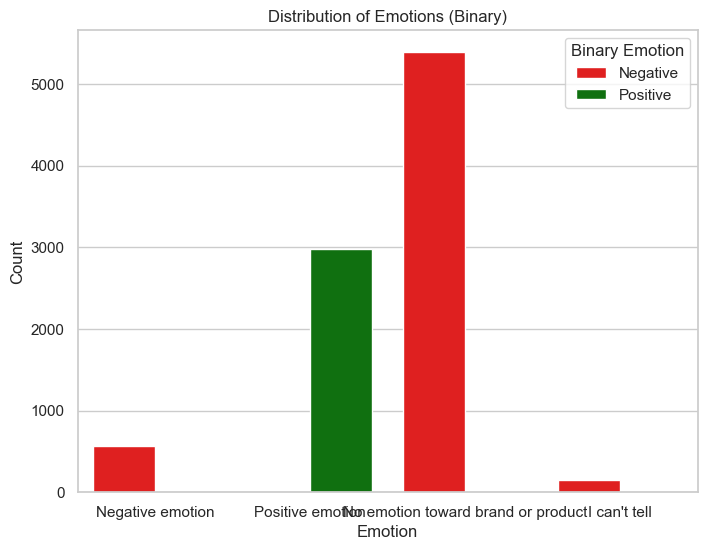

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df, hue='is_there_an_emotion_binary', palette={0: 'red', 1: 'green'})

# Add labels and title
plt.title('Distribution of Emotions (Binary)')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Show the legend
plt.legend(title='Binary Emotion', labels=['Negative', 'Positive'])

# Show the plot
plt.show()


# * check on how can't tell and no emotion 

In [10]:
# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

In [11]:
print("\nDistribution of 'emotion_in_tweet_is_directed_at' values:")
print(emotion_distribution)


Distribution of 'emotion_in_tweet_is_directed_at' values:
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64


In [12]:
df = df.dropna(subset=['emotion_in_tweet_is_directed_at'])


In [13]:
missing_values = df.isnull().sum()
print(missing_values)

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
is_there_an_emotion_binary                            0
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_8080\2831642955.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion_in_tweet_is_directed_at', data=df, palette="viridis")


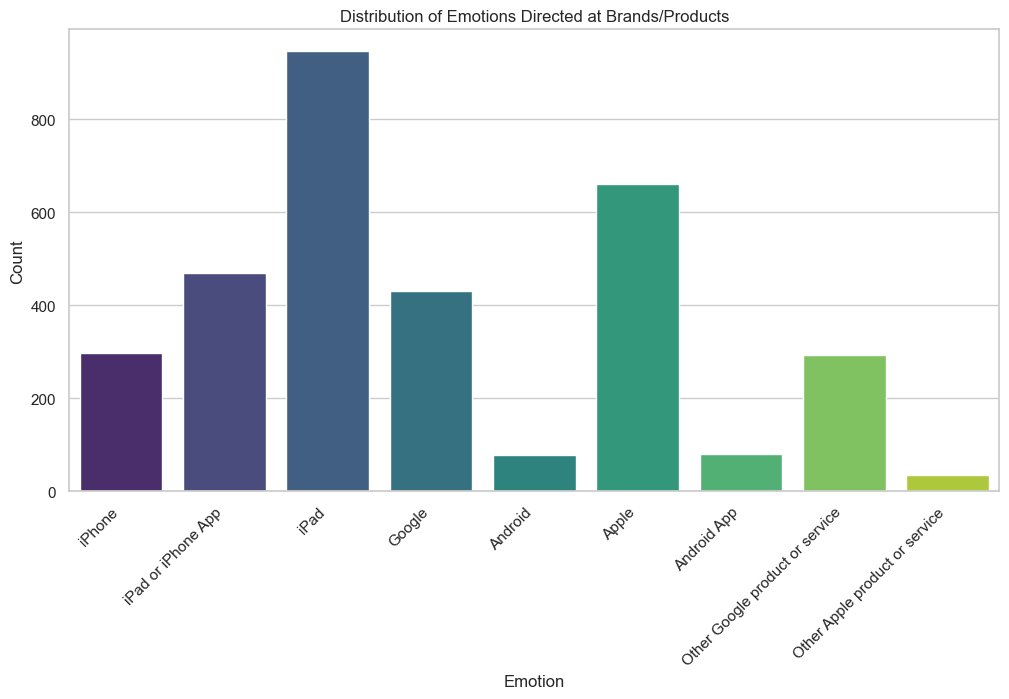

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a colorful count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


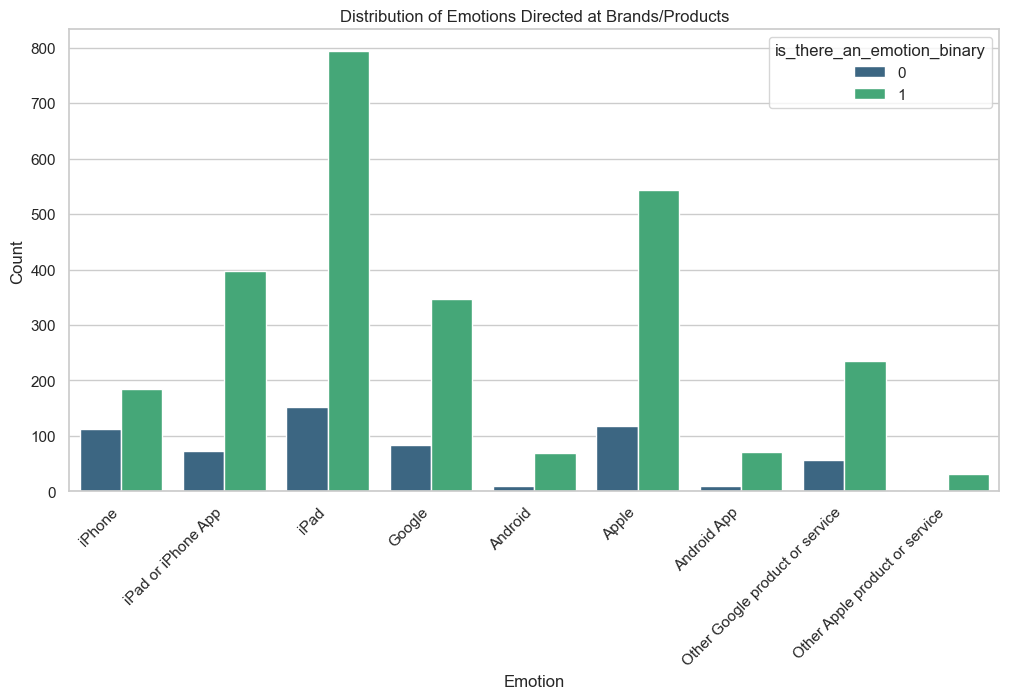

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a colorful count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', hue='is_there_an_emotion_binary', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


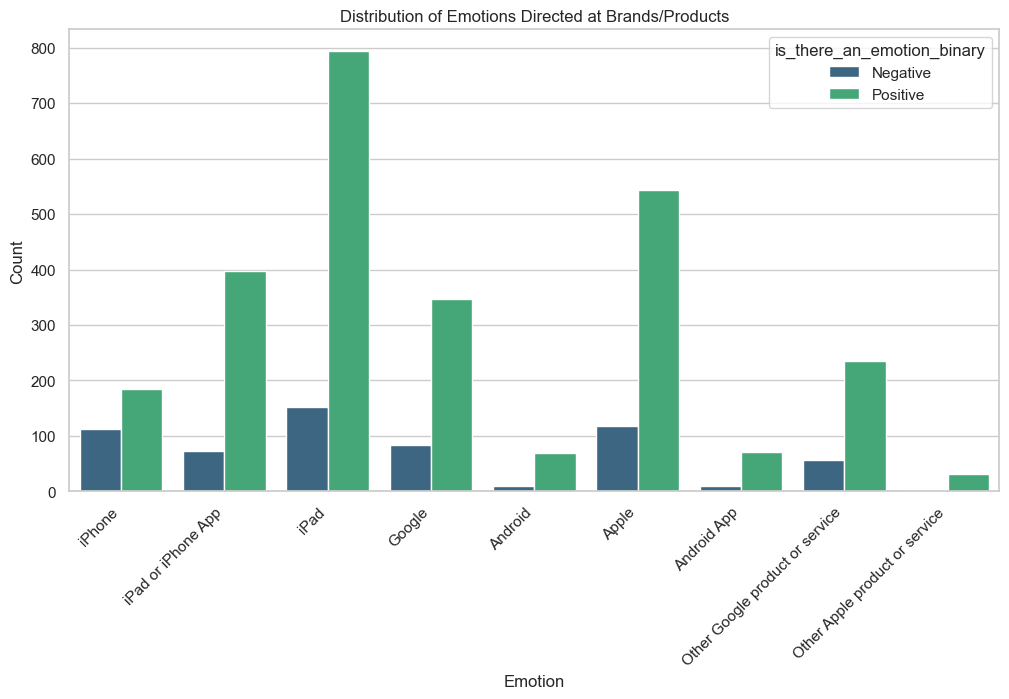

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 0 with 'Negative' and 1 with 'Positive'
df['is_there_an_emotion_binary'] = df['is_there_an_emotion_binary'].replace({0: 'Negative', 1: 'Positive'})

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a colorful count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', hue='is_there_an_emotion_binary', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [17]:

# Display the distributions
print("Distribution of 'tweet_text' values:")
print(tweet_text_distribution)


Distribution of 'tweet_text' values:
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                 5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                              4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                 4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                              3
RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter                                       2
                                                                                                                                              ..
Great interview to @mention on Bloomberg TV about #Ipad2 to kick off #SxSW.#apple {link}     

In [18]:
import nltk
from nltk.tokenize import word_tokenize

# Download the required resources
nltk.download('punkt')

# Tokenize the 'tweet_text' column
df['tokenized_text'] = df['tweet_text'].apply(word_tokenize)

# Display the tokenized text
print("Tokenized Text:")
print(df['tokenized_text'])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenized Text:
0       [., @, wesley83, I, have, a, 3G, iPhone, ., Af...
1       [@, jessedee, Know, about, @, fludapp, ?, Awes...
2       [@, swonderlin, Can, not, wait, for, #, iPad, ...
3       [@, sxsw, I, hope, this, year, 's, festival, i...
4       [@, sxtxstate, great, stuff, on, Fri, #, SXSW,...
                              ...                        
9077    [@, mention, your, PR, guy, just, convinced, m...
9079    [&, quot, ;, papyrus, ..., sort, of, like, the...
9080    [Diller, says, Google, TV, &, quot, ;, might, ...
9085    [I, 've, always, used, Camera+, for, my, iPhon...
9088           [Ipad, everywhere, ., #, SXSW, {, link, }]
Name: tokenized_text, Length: 3291, dtype: object


In [19]:
from string import punctuation

# Function for further tokenization
def further_tokenize(tokens):
    # Join the tokens into a single string
    text = ' '.join(tokens)

    # Remove newline characters
    text = text.replace('\n', ' ')

    # Remove specified punctuation marks
    text = ''.join([char.lower() for char in text if char not in punctuation])

    return text

# Apply further tokenization to the 'tokenized_text' column
df['further_tokenized_text'] = df['tokenized_text'].apply(further_tokenize)

# Display the further tokenized text
print("Further Tokenized Text:")
print(df['further_tokenized_text'])


Further Tokenized Text:
0         wesley83 i have a 3g iphone  after 3 hrs twe...
1        jessedee know about  fludapp  awesome ipadiph...
2        swonderlin can not wait for  ipad 2 also  the...
3        sxsw i hope this year s festival is nt as cra...
4        sxtxstate great stuff on fri  sxsw  marissa m...
                              ...                        
9077     mention your pr guy just convinced me to swit...
9079     quot  papyrus  sort of like the ipad  quot   ...
9080    diller says google tv  quot  might be run over...
9085    i ve always used camera for my iphone bc it ha...
9088                        ipad everywhere   sxsw  link 
Name: further_tokenized_text, Length: 3291, dtype: object


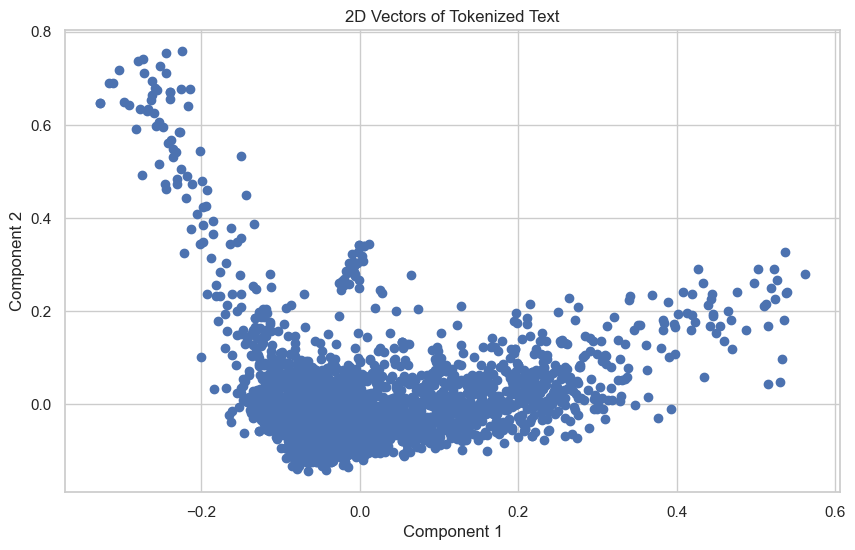

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['further_tokenized_text'])

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame for the 2D vectors
df_2d = pd.DataFrame(data=pca_result, columns=['Component 1', 'Component 2'])

# Display the 2D vectors
plt.figure(figsize=(10, 6))
plt.scatter(df_2d['Component 1'], df_2d['Component 2'])
plt.title('2D Vectors of Tokenized Text')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
